# PQuAD: A Persian question answering dataset

In [ ]:
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.8/477.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 34.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.0 MB/s eta 0:00:00


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.5 MB/s eta 0:00:00


In [ ]:
from datasets import Dataset as dtdt
from datasets import DatasetDict
from datasets import ClassLabel, Sequence
from datasets import load_dataset, load_metric
from torch.utils.data import DataLoader, Dataset
from transformers import get_linear_schedule_with_warmup, AdamW
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM , XLMRobertaForSequenceClassification , AutoModelForQuestionAnswering

import collections
import numpy as np
import transformers
import pandas as pd
from tqdm import tqdm
from torch import nn, optim

import hazm
import json
import time
import torch
import random
import warnings

import matplotlib.pyplot as plt
import torch.nn.functional as F
from datasets import load_dataset
from tqdm.notebook import tqdm_notebook

In [ ]:
!git clone https://github.com/AUT-NLP/PQuAD

fatal: destination path 'PQuAD' already exists and is not an empty directory.


In [ ]:
hazm_normalizer = hazm.Normalizer(
    persian_numbers=True, 
    persian_style=True, 
    remove_diacritics=True
)

In [ ]:
BEGIN_ANS_POS = "BEGIN_ANS_POS"
END_ANS_POS = "END_ANS_POS"
INPUT_IDS = "INPUT_IDS"
ATTENTION_MASK = "ATTENTION_MASK"
SAMPLE_ID = "SAMPLE_ID"
OFFSET_MAPPING = "OFFSET_MAPPING"
TOKEN_TYPE_IDS = "TOKEN_TYPE_IDS"

In [ ]:
class DFCreatorFromJson(object):
  def __init__(self):
    self.json_path = None
    self.data = None
    self.df_data = None

  def load_json(self, json_path):
    with open(json_path, encoding='utf-8') as f:
        self.data = json.load(f)

  def create_df_data(self):
    df_data = pd.DataFrame(columns=["id", "title", "context", "question", "answers"])

    for obj in tqdm(df_data["data"], total=len(df_data["data"])):
        title = obj["title"]
        paragraphs = obj["paragraphs"]

        for paragraph in paragraphs:
            context = paragraph["context"]
            qas = paragraph["qas"]

            for qas_obj in qas:
                question = qas_obj["question"]
                id = qas_obj["id"]
                answers = qas_obj["answers"]
                answer_list = []
                answer_text_list = []

                for answer in answers:
                    answer_list.append(answer["answer_start"])
                    answer_text_list.append(answer["text"])

                df_data = df_data.append(
                  {
                      "id": id, 
                      "title": title, 
                      "context": context, 
                      "question": question, 
                      "answers": {
                          'text': answer_text_list, 
                          'answer_start': answer_list
                        }
                  }, 
                  ignore_index=True
                )

    return df_data

  def get_df(self, json_path):
      self.load_json(json_path)
      return self.create_df_data()


In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)
df_creator = DFCreatorFromJson()

train_df = df_creator.get_df("./PQuAD/Dataset/Train.json")
valid_df = df_creator.get_df("./PQuAD/Dataset/Validation.json")
test_df = df_creator.get_df("./PQuAD/Dataset/Test.json")

100%|██████████| 114/114 [00:11<00:00, 10.03it/s]


In [ ]:
train_df

,id,title,context,question,answers
0,101001,آرسنال,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,موقعیت جغرافی باشگاه فوتبال آرسنال را بگویید؟,"{'text': ['شمال شهر لندن'], 'answer_start': [86]}"
1,101002,آرسنال,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,لیگ برتر انگلستان موفق به کسب چند عنوان قهرمان...,"{'text': ['۱۴'], 'answer_start': [173]}"
2,101003,آرسنال,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,بیشترین بازی بدون باخت پیاپی متعلق به کدام باش...,"{'text': ['باشگاه فوتبال انگلیسی'], 'answer_st..."
3,101004,آرسنال,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,باشگاه فوتبال آرسنال موفق به کسب چند عنوان قهر...,"{'text': ['۱۳'], 'answer_start': [119]}"
4,101005,آرسنال,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,باشگاه فوتبال آرسنال چند عنوان قهرمانی در جام ...,"{'text': ['۱۶'], 'answer_start': [214]}"
...,...,...,...,...,...
63989,1503901,ناصرالدین الطوسی,دو قرن پیش از خواجه، تحولات کلامی بنوعی با ابو...,ملاحمی از شاگردان چه کسی بود؟,"{'text': ['ابوالحسین بصری'], 'answer_start': [..."
63990,1503902,ناصرالدین الطوسی,دو قرن پیش از خواجه، تحولات کلامی بنوعی با ابو...,اندیشه‌های چه کسانی تأثیر بسزایی در فلسفی شدن...,"{'text': ['فخر رازی و ملاحمی و بصری'], 'answer..."
63991,1503903,ناصرالدین الطوسی,دو قرن پیش از خواجه، تحولات کلامی بنوعی با ابو...,ابوالحسین بصری کیست؟,"{'text': [], 'answer_start': []}"
63992,1503904,ناصرالدین الطوسی,دو قرن پیش از خواجه، تحولات کلامی بنوعی با ابو...,غزالی کیست؟,"{'text': [], 'answer_start': []}"


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63994 entries, 0 to 63993
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        63994 non-null  object
 1   title     63994 non-null  object
 2   context   63994 non-null  object
 3   question  63994 non-null  object
 4   answers   63994 non-null  object
dtypes: object(5)
memory usage: 2.4+ MB


In [ ]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7976 entries, 0 to 7975
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7976 non-null   object
 1   title     7976 non-null   object
 2   context   7976 non-null   object
 3   question  7976 non-null   object
 4   answers   7976 non-null   object
dtypes: object(5)
memory usage: 311.7+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8002 entries, 0 to 8001
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        8002 non-null   object
 1   title     8002 non-null   object
 2   context   8002 non-null   object
 3   question  8002 non-null   object
 4   answers   8002 non-null   object
dtypes: object(5)
memory usage: 312.7+ KB


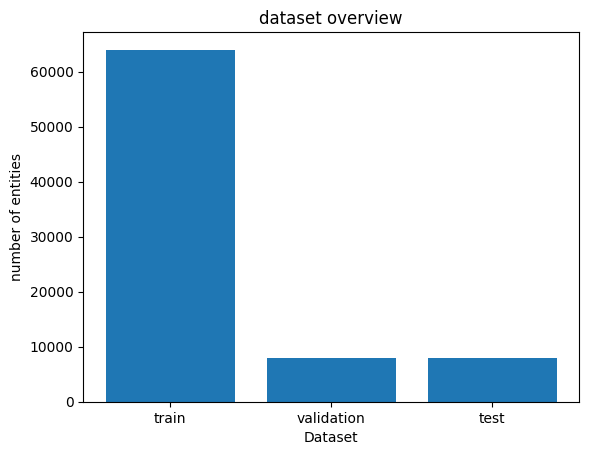

In [ ]:
plt.bar(['train', 'validation', 'test'], [len(train_df), len(valid_df), len(test_df)])
plt.xlabel('Dataset')
plt.ylabel('number of entities')
plt.title('dataset overview')
plt.show()

In [ ]:
[print(example) for example in train_df]

id
title
context
question
answers


[None, None, None, None, None]

In [ ]:
# answer_lengths.value_counts()

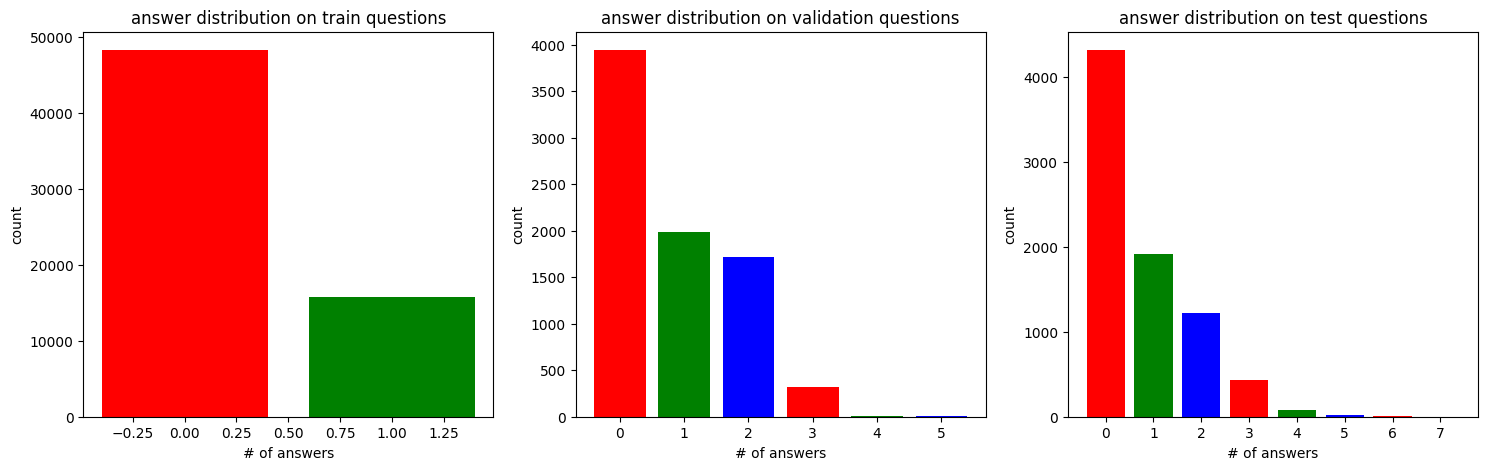

In [ ]:
plt.figure(figsize=(18, 5))
colors = ['red', 'green', 'blue']
answer_lengths = pd.Series([len(row['answers']['text']) for i, row in train_df.iterrows()])
plt.subplot(1, 3, 1)

plt.bar(np.arange(len(answer_lengths.value_counts())), answer_lengths.value_counts(), color=colors)
plt.xlabel('# of answers')
plt.ylabel('count')
plt.title('answer distribution on train questions')

answer_lengths = pd.Series([len(row['answers']['text']) for i, row in valid_df.iterrows()])
plt.subplot(1, 3, 2)
plt.bar(np.arange(len(answer_lengths.value_counts())), answer_lengths.value_counts(), color=colors)
plt.xlabel('# of answers')
plt.ylabel('count')
plt.title('answer distribution on validation questions')

answer_lengths = pd.Series([len(row['answers']['text']) for i, row in test_df.iterrows()])
plt.subplot(1, 3, 3)
plt.bar(np.arange(len(answer_lengths.value_counts())), answer_lengths.value_counts(), color=colors)
plt.xlabel('# of answers')
plt.ylabel('count')
plt.title('answer distribution on test questions')

plt.show()

In [ ]:
ds = DatasetDict()
ds['train'] = dtdt.from_pandas(train_df)
ds['validation'] = dtdt.from_pandas(valid_df)
ds["test"] = dtdt.from_pandas(test_df)

In [ ]:
ds['train']

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 63994
})

In [ ]:
ds['validation']

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 7976
})

In [ ]:
ds['test']

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 8002
})

In [ ]:
def tokenize(tokenizer, max_len, dataset, lbs = LOADING_BATCH_SIZE , stride = STRIDE) :
    for i in tqdm ( range ( 0 , dataset.shape[0] , lbs) ):
        mini_data = dataset[i : i + lbs]
        tokenized_mini_data = batch_tokenizer ( mini_data  , tokenizer  , max_len , stride )

        if i == 0 : encoded_inputs = tokenized_mini_data
        else :
            for key in encoded_inputs :
                encoded_inputs[key] += tokenized_mini_data[key]
    return encoded_inputs

In [ ]:
def batch_tokenizer_util(answers, encoded_inputs):
    if len(answers["answer_start"]) == 0:
        encoded_inputs[BEGIN_ANSWER_POS].append(cls_index)
        encoded_inputs[END_ANSWER_POS].append(cls_index)
    else:
        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0])

        context_first_token_idx = 0
        while sequence_ids[context_first_token_idx] != 1 :
            context_first_token_idx += 1

        context_last_token_idx = len(input_ids) - 1
        while sequence_ids[context_last_token_idx] != 1:
            context_last_token_idx -= 1

        if (offsets[context_first_token_idx][0] <= start_char and offsets[context_last_token_idx][1] >= end_char):
            answer_start_index = context_first_token_idx
            while answer_start_index < len(offsets) and offsets[answer_start_index][0] <= start_char:
                answer_start_index += 1
            encoded_inputs[BEGIN_ANSWER_POS].append(answer_start_index - 1)

            answer_end_index = context_last_token_idx
            while offsets[answer_end_index][1] >= end_char:
                answer_end_index -= 1
            encoded_inputs[END_ANSWER_POS].append(answer_end_index + 1)

        else:
            encoded_inputs[BEGIN_ANSWER_POS].append(cls_index)
            encoded_inputs[END_ANSWER_POS].append(cls_index)

        encoded_inputs["offset_mapping"][i] = [
              (offset if sequence_ids[j] == context_id else (0,0))
              for j, offset in enumerate(encoded_inputs["offset_mapping"][i])]


In [ ]:
def batch_tokenizer(self, inputs, tokenizer, max_len, stride):
    question = inputs['question']  # Extract the 'question' from the inputs dictionary
    context = inputs['context']  # Extract the 'context' from the inputs dictionary

    encoded_inputs = tokenizer(question, context, truncation='only_second', max_length=max_len,
        padding="max_length", stride=stride, return_overflowing_tokens=True, return_offsets_mapping=True,
    )

    encoded_inputs[BEGIN_ANSWER_POS] = []  # Initialize an empty list for the beginning positions of answers
    encoded_inputs[END_ANSWER_POS] = []  # Initialize an empty list for the ending positions of answers
    encoded_inputs[SAMPLE_ID] = []  # Initialize an empty list for sample IDs
    offset_mapping = encoded_inputs["offset_mapping"]  # Get the offset mapping for tokenized inputs
    sample_mapping = encoded_inputs.pop("overflow_to_sample_mapping")  # Remove the 'overflow_to_sample_mapping' key from encoded_inputs and assign it to sample_mapping

    for i, offsets in enumerate(offset_mapping):
        input_ids = encoded_inputs["input_ids"][i]  # Get the input_ids for the current offset mapping
        cls_index = input_ids.index(tokenizer.cls_token_id)  # Find the index of the [CLS] token in input_ids
        sequence_ids = encoded_inputs.sequence_ids(i)  # Get the sequence IDs for the current offset mapping
        context_id = 1  # Assign the value 1 to the context ID (assuming it represents the second sequence)

        sample_index = sample_mapping[i]  # Get the sample index for the current offset mapping
        encoded_inputs["sample_id"].append(inputs["id"][sample_index])  # Append the sample ID to the 'sample_id' list in encoded_inputs
        answers = inputs["answers"][sample_index]  # Get the answers for the current sample index

        batch_tokenizer_util(answers, encoded_inputs) 

    return encoded_inputs

In [ ]:
class CustomDataset(dtdt):
    
    def __init__(self, dataset , tokenizer , max_len ):
        self.dataset=dataset
        self.encoded_inputs = tokenize(
            tokenizer, 
            max_len, 
            dataset 
        )

    def __len__(self):
        return len( self.encoded_inputs[INPUT_IDS] )
    
    def __getitem__(self,item):
        input_ids = []
        attention_mask = []
        token_type_ids = []
        ans_start_pos = []
        ans_end_pos = []
        sample_id = []
        offset_mapping= []

        for i in item:
          input_ids.append( 
              torch.tensor(
                  self.encoded_inputs[INPUT_IDS][i] 
                  )
              )
          attention_mask.append(
              torch.tensor(
                  self.encoded_inputs[ATTENTION_MASK][i] 
              )
          )
          ans_start_pos.append(
              self.encoded_inputs[BEGIN_ANS_POS][i]
          )
          ans_end_pos.append(
              self.encoded_inputs[END_ANS_POS][i]
          )
          sample_id.append(
              self.encoded_inputs[SAMPLE_ID][i]
          )
          offset_mapping.append(
              self.encoded_inputs[OFFSET_MAPPING][i]
          )
          token_type_ids.append(
              torch.tensor(
                   self.encoded_inputs[TOKEN_TYPE_IDS][i]
              )
          )


        return {
            INPUT_IDS : input_ids,
            ATTENTION_MASK : attention_mask,
            BEGIN_ANS_POS : ans_start_pos,
            END_ANS_POS : ans_end_pos,
            SAMPLE_ID : sample_id,
            OFFSET_MAPPING : offset_mapping,
            TOKEN_TYPE_IDS : token_type_ids
        }
        
    

In [ ]:
def BuildDataLoaders( tokenizer , max_len):
    train_set = ds['train']
    val_set = ds['validation']
    test_set = ds["test"]
  
    print('TOKENIZING SETS\n')
    train_dl = torch.utils.data.DataLoader(  
        CustomDataset( train_set , tokenizer , max_len ) , 
        batch_size = train_bs , 
        shuffle = True  
    )
    val_dl = torch.utils.data.DataLoader( 
         CustomDataset( val_set , tokenizer , max_len  ) , 
         batch_size = test_val_bs , 
         shuffle = True  
    )
    test_dl = torch.utils.data.DataLoader(  
        CustomDataset( test_set , tokenizer , max_len  ) , 
        batch_size = test_val_bs , 
        shuffle = True
    )

    return train_dl, val_dl, val_set,  test_dl, test_set

In [ ]:
class BaseModel(nn.Module):
    
    def __init__(self, model_type):
        super().__init__()
        # Initialize the base transformer model from the pretrained weights
        self.transformer = AutoModel.from_pretrained(model_type)
        # Apply dropout regularization with a probability of 0.2
        self.drop = nn.Dropout(p=0.2)
        # Create a fully connected layer with the output size equal to the hidden size of the transformer and 2 output units
        self.fc = nn.Linear(self.transformer.config.hidden_size, 2)
        
    def forward(self, input_ids, token_type_ids, attention_mask):
        # Forward pass through the transformer model
        output = self.transformer(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        # Apply the fully connected layer to the output of the transformer
        output = self.fc(output[0]) 
        # Split the output into start and end positions for the answer
        ans_start_pos, ans_end_pos = output.split(1, dim=-1)
        # Remove the last dimension (squeeze) to obtain 1D tensors
        ans_start_pos = ans_start_pos.squeeze(-1)
        ans_end_pos = ans_end_pos.squeeze(-1)

        # Return the start and end positions of the answer
        return ans_start_pos, ans_end_pos

In [ ]:
def criterion(start_true, end_true, start_pred, end_pred):
    # Get the maximum index of the input
    max_input_index = start_pred.size(1)
    
    # Clamp the true start and end values to be within the valid range
    start_true.clamp_(0, max_input_index)
    end_true.clamp_(0, max_input_index)
    
    # Define the CrossEntropyLoss function with the ignore_index parameter
    ce = torch.nn.CrossEntropyLoss(ignore_index=max_input_index)
    
    # Calculate the loss for the predicted start and end values
    start_loss = ce(start_pred, start_true)
    end_loss = ce(end_pred, end_true)
    
    # Calculate the average loss between start and end losses
    res = (start_loss + end_loss) / 2
    
    return res


In [ ]:
def fetch_predictions(batch, start_logits, end_logits, predictions):
    # Extracting values from the batch
    offset_mapping = batch['offset_mapping']
    sample_ids = batch['sample_id']
    input_ids = batch['input_ids']
    
    # Converting offset_mapping to numpy arrays
    offset_mapping0 = np.array([[t.numpy().tolist() for t in subtle][0] for subtle in offset_mapping])
    offset_mapping0 = offset_mapping0.T
    offset_mapping1 = np.array([[t.numpy().tolist() for t in subtle][1] for subtle in offset_mapping])
    offset_mapping1 = offset_mapping1.T
    
    # Iterating over each input in the batch
    for i in range(len(batch['input_ids'])):
        # Creating a dictionary with predictions for the current input
        prediction = {
            'sample_id': sample_ids[i],
            'offset_mapping': [offset_mapping0[i], offset_mapping1[i]],
            'input_ids': input_ids[i],
            'end_logits': end_logits[i],
            'start_logits': start_logits[i],
        }
        # Appending the prediction to the list of predictions
        predictions.append(prediction)

    return predictions


In [ ]:
def predict_per_index(predictions, valid_answers):
  start_logits = predictions[preds_index]['start_logits']
  end_logits = predictions[preds_index]['end_logits']
  offset_mapping = predictions[preds_index]["offset_mapping"]
  cls_index = predictions[preds_index]["input_ids"].numpy().tolist().index(tokenizer.cls_token_id)
  pred_null_score = start_logits[cls_index] + end_logits[cls_index]
  if min_null_score is None or min_null_score < pred_null_score:
      min_null_score = pred_null_score

  best_start_indexes = np.flip( np.argsort( start_logits ) ).tolist()[: n_best_size]
  best_end_indexes = np.flip( np.argsort( end_logits ) ).tolist()[: n_best_size]

  for start_index in best_start_indexes:
      for end_index in best_end_indexes:
          if ( not ( start_index >= len(offset_mapping) ) or not ( end_index >= len(offset_mapping) ) or
                not ( end_index < start_index ) or not ( end_index - start_index + 1 > max_answer_length ) or 
                not (torch.all( offset_mapping[start_index] is torch.Tensor([0,0]) )) or not (torch.all( offset_mapping[end_index] is torch.Tensor([0,0]) )) or offset_mapping[end_index]):
              
              start_char = offset_mapping[0][start_index]
              end_char = offset_mapping[1][end_index]
              

              valid_answer = {"score": start_logits[start_index] + end_logits[end_index], "text": context[start_char: end_char]}
              valid_answers.append( valid_answer )

In [ ]:
def get_final_predictions(predictions, inputs, tokenizer):
    # Set parameters
    n_best_size = 20
    max_answer_length = 20

    # Create a mapping of sample IDs to their corresponding indices
    sample_idToIndex = {id: index for index, id in enumerate(inputs["id"])}

    # Create a dictionary to store predictions for each sample index
    pred_per_samples = collections.defaultdict(list)

    # Group predictions by sample index
    for i, pred in enumerate(predictions):
        pidx = pred["sample_id"]
        sit = sample_idToIndex[pidx]
        pred_per_samples[sit].append(i)

    # Create an ordered dictionary to store final predictions
    final_predictions = collections.OrderedDict()

    # Iterate over each sample
    for sample_index, sample in enumerate(inputs):
        preds_indices = pred_per_samples[sample_index]  # Get prediction indices for the current sample
        min_null_score = None
        valid_answers = []
        context = sample["context"]

        # Iterate over each prediction index for the current sample
        for preds_index in preds_indices:
            # Call the function predict_per_index to process predictions and populate valid_answers
            predict_per_index(predictions, valid_answers)

        # Choose the best answer from valid answers
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            best_answer = {"text": "", "score": 0.0}

        # Assign the answer to the current sample ID in the final predictions dictionary
        answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
        final_predictions[sample["id"]] = answer

    return final_predictions

In [ ]:
def fetch_metrics (predictions , raw_input , tokenizer) :
    final_predictions = postprocess_predictions(predictions , raw_input , tokenizer)
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
    ground_trouth = [{"id": sample["id"], "answers": sample["answers"]} for sample in raw_input]
    return load_metric("squad_v2" ).compute(predictions=formatted_predictions, references = ground_trouth)

In [ ]:
def evaluate(model , dataloader , criterion , raw_input , tokenizer ) :
    
    model.eval()
    losses , predictions = [],[]
    
    for batch in dataloader:
    
        input_ids = batch[INPUT_IDS].to(device)
        attention_mask = batch[ATTENTION_MASK].to(device)
        answer_sp = batch[BEGIN_ANSER_POS].to(device)
        answer_ep = batch[END_ANSWER_POS].to(device)
        token_type_ids = batch[TOKEN_TYPE_IDS].to(device)
        with torch.no_grad():
          start_logits , end_logits  = model(input_ids = input_ids ,token_type_ids=token_type_ids, attention_mask = attention_mask  )
        predictions = fetch_predictions(batch  , start_logits.cpu().detach().numpy() , 
                                          end_logits.cpu().detach().numpy() , predictions )

        loss = criterion(answer_sp, answer_ep , start_logits , end_logits)
        losses.append(loss.item())

    metrics = fetch_metrics(predictions , raw_input , tokenizer)
    return  np.mean(losses) , metrics['exact'] , metrics['f1']

In [ ]:
def train(model , dataloader , optimizer , criterion  , epoch ) :
    
    model.train()
    losses =  []  
    print(len(dataloader))  
    for iteration , batch in enumerate(tqdm_notebook(dataloader)) :
          
        optimizer.zero_grad()
        input_ids = batch[INPUT_IDS].to(device)
        attention_mask = batch[ATTENTION_MASK].to(device)
        answer_sp = batch[BEGIN_ANSER_POS].to(device)
        answer_ep = batch[END_ANSWER_POS].to(device)
        token_type_ids = batch[TOKEN_TYPE_IDS].to(device)

        start , end  = model(input_ids = input_ids ,token_type_ids=token_type_ids, attention_mask = attention_mask  )
    
        loss = criterion(answer_sp, answer_ep , start , end)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if iteration % 100 == 0:
            print( f'Epoch [{epoch+1}] Batch [{iteration}] - Loss = {np.mean(losses):.4f}')
            
    return  np.mean(losses)

In [ ]:
def getModel(model_type, device):
    return BaseModel(model_type).to(device)

In [ ]:
EPOCHS = 1

LEARNING_RATE = 5e-5

TRAIN_BATCH_SIZE = 16

MAX_LEN = 512

GAMMA = 0.1

STEP = 1

MAX_ANS_LEN = 20

MODEL_TYPE = "HooshvareLab/bert-base-parsbert-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = getModel(MODEL_TYPE)

cuda is available


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer  =  AutoTokenizer.from_pretrained(cem )
train_dataloader , val_dataloader , val_set , test_dataloader , test_set  = getDataLoaders( tokenizer , max_length )

print('train batches num: ',len(train_dataloader))
print('validaion batches num: ',len(val_dataloader))
print('test batches num: ',len(test_dataloader)  )

TOKENIZING SETS



100%|██████████| 9/9 [00:08<00:00,  1.05it/s]

train batches num:  4000
validaion batches num:  1994
test batches num:  2001


In [ ]:
optimizer  = AdamW(model.parameters(), lr=5e-5,weight_decay=weight_decay) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = sch_step, gamma = sch_gamma)
criterion = loss_function

best_accuracy = 0
loss_list , metric_list =[],[]

for epock in range(epocks):

    train_loss = train( model , train_dataloader , optimizer , criterion , epock )
    val_loss , exact_match , f1_score = evaluate( model , val_dataloader , criterion , val_set , tokenizer )
    scheduler.step()
    
    loss_list.append([train_loss , val_loss])
    metric_list.append([exact_match , f1_score])

    print(f'Train Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f} - Exact Match: {exact_match:.3f} - F1_score: {f1_score:.3f}', '\n')

4000


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch [1] Batch [0] - Loss = 6.2101
Epoch [1] Batch [100] - Loss = 2.3668
Epoch [1] Batch [200] - Loss = 1.8774
Epoch [1] Batch [300] - Loss = 1.6675
Epoch [1] Batch [400] - Loss = 1.5423
Epoch [1] Batch [500] - Loss = 1.4520
Epoch [1] Batch [600] - Loss = 1.3895
Epoch [1] Batch [700] - Loss = 1.3406
Epoch [1] Batch [800] - Loss = 1.2955
Epoch [1] Batch [900] - Loss = 1.2622
Epoch [1] Batch [1000] - Loss = 1.2322
Epoch [1] Batch [1100] - Loss = 1.2087
Epoch [1] Batch [1200] - Loss = 1.1902
Epoch [1] Batch [1300] - Loss = 1.1681
Epoch [1] Batch [1400] - Loss = 1.1513
Epoch [1] Batch [1500] - Loss = 1.1361
Epoch [1] Batch [1600] - Loss = 1.1235
Epoch [1] Batch [1700] - Loss = 1.1099
Epoch [1] Batch [1800] - Loss = 1.0987
Epoch [1] Batch [1900] - Loss = 1.0871
Epoch [1] Batch [2000] - Loss = 1.0788
Epoch [1] Batch [2100] - Loss = 1.0669
Epoch [1] Batch [2200] - Loss = 1.0584
Epoch [1] Batch [2300] - Loss = 1.0500
Epoch [1] Batch [2400] - Loss = 1.0450
Epoch [1] Batch [2500] - Loss = 1.039

Train Loss: 0.9689
Validation Loss: 0.8452 - Exact Match: 69.709 - F1_score: 82.936 



In [ ]:
print(loss_list)

[[0.9689259925708175, 0.8452220881738912]]


In [ ]:
import matplotlib.pyplot as plt

train_losses = [item[0] for item in loss_list]
val_losses = [item[1] for item in loss_list]
exact_match_scores = [item[0] for item in metric_list]
f1_scores = [item[1] for item in metric_list]

print('Train loss = ', train_losses[0])
print('Validation loss = ', val_losses[0])
print("Exact Match score = ", exact_match_scores[0])
print('F1 score = ', f1_score)
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(epocks, train_losses, label='Train Loss')
# plt.plot(epocks, val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epocks, exact_match_scores, label='Exact Match')
# plt.plot(epocks, f1_scores, label='F1-score')
# plt.xlabel('Epochs')
# plt.ylabel('Score')
# plt.title('Exact Match and F1-score')
# plt.legend()

# plt.tight_layout()
# plt.show()

Train loss =  0.9689259925708175
Validation loss =  0.8452220881738912
Exact Match score =  69.70912738214643
F1 score =  82.93638169533077


In [ ]:
val_loss , exact_match , f1_score, losses = evaluate( model , val_dataloader , criterion , val_set , tokenizer )
scheduler.step()

loss_list.append([train_loss , val_loss])
metric_list.append([exact_match , f1_score])

print(f'Train Loss: {train_loss:.4f}')
print(f'Validation Loss: {val_loss:.4f} - Exact Match: {exact_match:.3f} - F1_score: {f1_score:.3f}', '\n')

Train Loss: 0.9689
Validation Loss: 0.8452 - Exact Match: 69.709 - F1_score: 82.936 



In [ ]:
print(losses)
print(len(losses))

[0.4592438042163849, 0.6782841682434082, 0.06826084852218628, 0.47528648376464844, 0.5622397065162659, 0.9232022762298584, 1.9538650512695312, 2.482419013977051, 0.38028445839881897, 0.16494213044643402, 1.1415650844573975, 0.5171568393707275, 0.6259753704071045, 1.8200550079345703, 0.7236332893371582, 0.24572333693504333, 0.2522115409374237, 0.11354091763496399, 0.14212524890899658, 0.7152316570281982, 1.146888256072998, 1.5528031587600708, 0.2567753791809082, 0.4301542639732361, 1.4488012790679932, 1.4202868938446045, 0.4416458010673523, 0.6717694401741028, 3.005591869354248, 0.22215589880943298, 0.35010337829589844, 0.3849765658378601, 2.4500339031219482, 0.1028842106461525, 0.8428153991699219, 2.0725464820861816, 0.8737446665763855, 0.9457417130470276, 0.13658460974693298, 0.5902531743049622, 0.2696884572505951, 0.7446228265762329, 1.9915757179260254, 0.6089973449707031, 2.104604959487915, 1.8394854068756104, 0.8225216865539551, 0.12268786132335663, 1.1289105415344238, 0.4952801465

In [ ]:
some_losses = losses[::100]

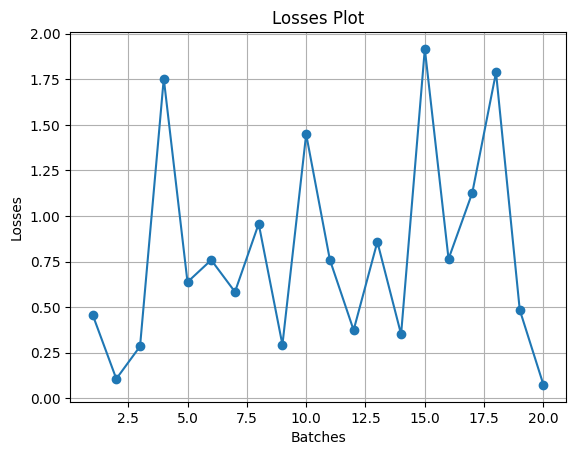

In [ ]:
batches = range(1, len(some_losses) + 1)
plt.plot(batches, some_losses, marker='o')
plt.xlabel('Batches')
plt.ylabel('Losses')
plt.title('Losses Plot')
plt.grid(True)
plt.show()

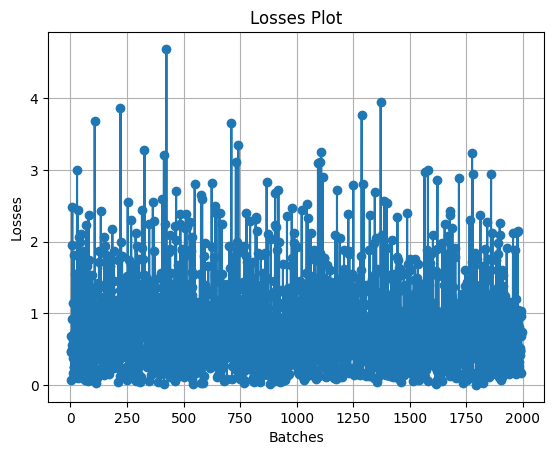

In [ ]:
batches = range(1, len(losses) + 1)
plt.plot(batches, losses, marker='o')
plt.xlabel('Batches')
plt.ylabel('Losses')
plt.title('Losses Plot')
plt.grid(True)
plt.show()

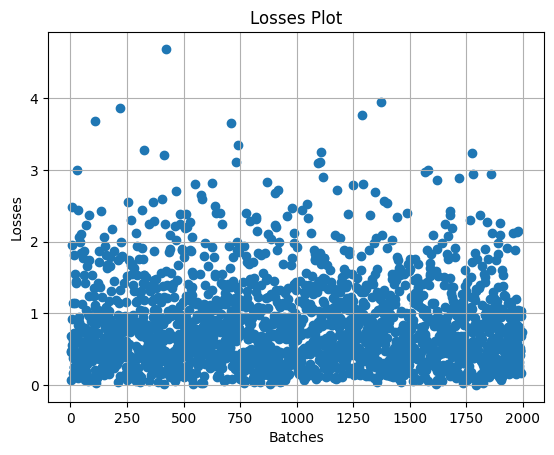

In [ ]:
batches = range(1, len(losses) + 1)
plt.scatter(batches, losses, marker='o')
plt.xlabel('Batches')
plt.ylabel('Losses')
plt.title('Losses Plot')
plt.grid(True)
plt.show()

In [ ]:
!pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.


In [ ]:
epocks = 1
learning_rate = 5e-5
train_bs = 16
test_val_bs = 4
max_length = 512
sch_gamma = 0.1
weight_decay=0.1
sch_step = 1
max_answer_length = 20

cem = "m3hrdadfi/albert-fa-base-v2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = getModel(cem)

tokenizer  =  AutoTokenizer.from_pretrained(cem )
train_dataloader , val_dataloader , val_set , test_dataloader , test_set  = getDataLoaders( tokenizer , max_length )

print('train batches num: ',len(train_dataloader))
print('validaion batches num: ',len(val_dataloader))
print('test batches num: ',len(test_dataloader)  )

optimizer  = AdamW(model.parameters(), lr=5e-5,weight_decay=weight_decay) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = sch_step, gamma = sch_gamma)
criterion = loss_function

best_accuracy = 0
loss_list , metric_list =[],[]
losses = []

for epock in range(epocks):

    train_loss = train( model , train_dataloader , optimizer , criterion , epock )
    val_loss , exact_match , f1_score, losses = evaluate( model , val_dataloader , criterion , val_set , tokenizer )
    scheduler.step()
    
    loss_list.append([train_loss , val_loss])
    metric_list.append([exact_match , f1_score])

    print(f'Train Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f} - Exact Match: {exact_match:.3f} - F1_score: {f1_score:.3f}', '\n')

Some weights of the model checkpoint at m3hrdadfi/albert-fa-base-v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'sop_classifier.classifier.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'sop_classifier.classifier.bias', 'predictions.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TOKENIZING SETS



100%|██████████| 9/9 [00:09<00:00,  1.04s/it]

train batches num:  4000
validaion batches num:  1994
test batches num:  2001
4000


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch [1] Batch [0] - Loss = 6.3337
Epoch [1] Batch [100] - Loss = 2.4728
Epoch [1] Batch [200] - Loss = 1.9348
Epoch [1] Batch [300] - Loss = 1.6782
Epoch [1] Batch [400] - Loss = 1.5350
Epoch [1] Batch [500] - Loss = 1.4389
Epoch [1] Batch [600] - Loss = 1.3681
Epoch [1] Batch [700] - Loss = 1.3158
Epoch [1] Batch [800] - Loss = 1.2748
Epoch [1] Batch [900] - Loss = 1.2406
Epoch [1] Batch [1000] - Loss = 1.2107
Epoch [1] Batch [1100] - Loss = 1.1852
Epoch [1] Batch [1200] - Loss = 1.1663
Epoch [1] Batch [1300] - Loss = 1.1459
Epoch [1] Batch [1400] - Loss = 1.1245
Epoch [1] Batch [1500] - Loss = 1.1042
Epoch [1] Batch [1600] - Loss = 1.0881
Epoch [1] Batch [1700] - Loss = 1.0724
Epoch [1] Batch [1800] - Loss = 1.0574
Epoch [1] Batch [1900] - Loss = 1.0462
Epoch [1] Batch [2000] - Loss = 1.0324
Epoch [1] Batch [2100] - Loss = 1.0202
Epoch [1] Batch [2200] - Loss = 1.0108
Epoch [1] Batch [2300] - Loss = 1.0020
Epoch [1] Batch [2400] - Loss = 0.9926
Epoch [1] Batch [2500] - Loss = 0.984

Train Loss: 0.9030
Validation Loss: 0.8356 - Exact Match: 69.458 - F1_score: 83.103 



In [ ]:
print(loss_list)

[[0.9029691249467432, 0.8356281093589367]]


In [ ]:
import matplotlib.pyplot as plt

train_losses = [item[0] for item in loss_list]
val_losses = [item[1] for item in loss_list]
exact_match_scores = [item[0] for item in metric_list]
f1_scores = [item[1] for item in metric_list]

print('Train loss = ', train_losses[0])
print('Validation loss = ', val_losses[0])
print("Exact Match score = ", exact_match_scores[0])
print('F1 score = ', f1_score)

Train loss =  0.9029691249467432
Validation loss =  0.8356281093589367
Exact Match score =  69.45837512537612
F1 score =  83.10285133774518


In [ ]:
val_loss , exact_match , f1_score, losses = evaluate( model , val_dataloader , criterion , val_set , tokenizer )
scheduler.step()

loss_list.append([train_loss , val_loss])
metric_list.append([exact_match , f1_score])

print(f'Train Loss: {train_loss:.4f}')
print(f'Validation Loss: {val_loss:.4f} - Exact Match: {exact_match:.3f} - F1_score: {f1_score:.3f}', '\n')

Train Loss: 0.9030
Validation Loss: 0.8356 - Exact Match: 69.458 - F1_score: 83.103 



In [ ]:
print(losses)
print(len(losses))

[0.7116424441337585, 1.0200138092041016, 0.8046568632125854, 0.34314513206481934, 1.9301888942718506, 0.08626769483089447, 1.8332585096359253, 0.9897695779800415, 1.331455945968628, 0.7007160186767578, 0.9251720905303955, 0.3906165063381195, 1.2329331636428833, 0.20899036526679993, 0.3149751126766205, 1.1371145248413086, 0.9177895784378052, 0.3910723030567169, 0.6563191413879395, 1.2089062929153442, 0.8428142070770264, 1.4779845476150513, 1.433534026145935, 0.8977805972099304, 0.6870713829994202, 0.600368857383728, 0.37432509660720825, 1.079483151435852, 1.3731478452682495, 1.5225945711135864, 0.8767184019088745, 0.27050769329071045, 0.184853196144104, 0.4969116151332855, 0.7128704190254211, 1.9483205080032349, 2.00199031829834, 0.24756702780723572, 0.20074060559272766, 0.9500386714935303, 1.3035457134246826, 0.34371310472488403, 1.749469518661499, 0.33030563592910767, 0.9653369188308716, 1.2989060878753662, 1.4739658832550049, 1.7315120697021484, 1.751258134841919, 0.4935382008552551,

In [ ]:
some_losses = losses[::100]

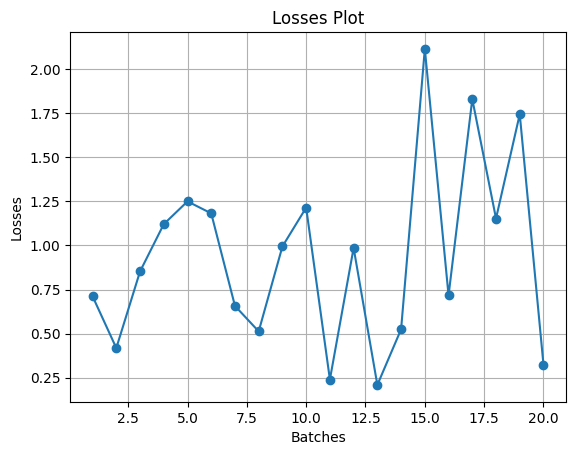

In [ ]:
batches = range(1, len(some_losses) + 1)
plt.plot(batches, some_losses, marker='o')
plt.xlabel('Batches')
plt.ylabel('Losses')
plt.title('Losses Plot')
plt.grid(True)
plt.show()

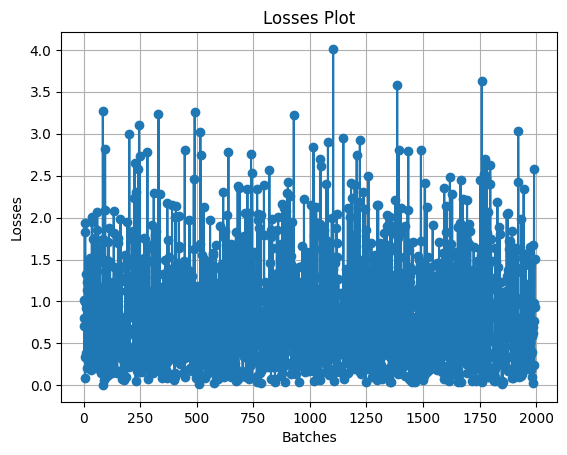

In [ ]:
batches = range(1, len(losses) + 1)
plt.plot(batches, losses, marker='o')
plt.xlabel('Batches')
plt.ylabel('Losses')
plt.title('Losses Plot')
plt.grid(True)
plt.show()

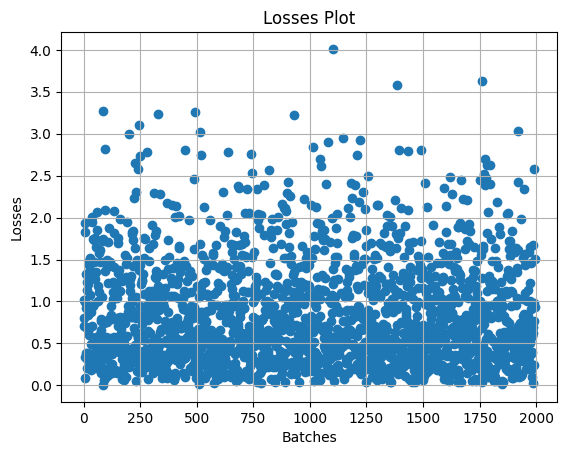

In [ ]:
batches = range(1, len(losses) + 1)
plt.scatter(batches, losses, marker='o')
plt.xlabel('Batches')
plt.ylabel('Losses')
plt.title('Losses Plot')
plt.grid(True)
plt.show()